## Notebook for sample QC of WGS sample cohort

#### library imports and global variables

In [1]:
# import libraries
import threading
import pandas as pd
import dask.dataframe as dd
import os
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# global notebook variables for both python and bash magic (by stdin arguments)
cohort = 'foundin'
build = 'freeze9'
cohort_build = f'{cohort}.{build}'
amppd_version = 'amppdv1'

# directories
wrk_dir = f'/labshare/raph/datasets/{cohort}'
genos_dir = f'{wrk_dir}/genotypes'
qc_dir = f'{wrk_dir}/qc'
eqtl_geno_dir = f'/labshare/raph/eqtl/{cohort}/genotypes'
eqtl_info_dir = f'/labshare/raph/eqtl/{cohort}/sample_info'

# out file
qc_bfile_set = f'{qc_dir}/{cohort_build}.geno05maf05hwe000001'
sqc_excludes_file = f'{qc_dir}/{cohort_build}.excludes.txt'
sample_info_file = f'{eqtl_info_dir}/{cohort_build}.sample_info.txt'

# constants
autosomes = [str(x) for x in list(range(1,23))]
sexomes = ['X']
chromosomes = autosomes + sexomes
MAX_MISSING = 0.05
MIN_FREQ = 0.05
MIN_HWE_P = 0.000001
hg38_chrX_PAREND = 2800000
hg38_chrX_PARSTART = 155700000

# known samples that need to be removed from analyses
known_excludes = ['PP-50670']

#### threading related functions

In [3]:
#### threading related function

# run command line procsss with bash majic
# make this a small function so it can be target function for threading
def run_bash_cmd(this_cmd):
    !{this_cmd}

# for each bash command is list add to execution thread, join and wait til all done
def run_bash_cmds_threaded(cmd_list):
    job_threads = []
    for this_cmd in cmd_list:
        this_thread = threading.Thread(target=run_bash_cmd, args=(this_cmd,))
        job_threads.append(this_thread)
        this_thread.start()

    for job_thread in job_threads:
        job_thread.join()          

### run typical QC checks

#### create output directories

In [4]:
os.makedirs(qc_dir, exist_ok=True)
os.makedirs(eqtl_geno_dir, exist_ok=True)
os.makedirs(eqtl_info_dir, exist_ok=True)

#### subset genotypes to well behaved variants for running typical sample QC

In [5]:
# %%time
# # since the plink bim file does handle multi-allelics need to find and create
# # exclude list for if bfiles need

# def find_pvar_multiallelics(pvar_file, outfile):
#     pvar_dd = dd.read_csv(pvar_file, header=None, sep='\s+', comment='#',
#                           usecols=[0, 2, 4],
#                           dtype={0: 'string', 2: 'string', 4: 'string'})

#     # see if ALT allele(s) column contains commas
#     multiallelics = pvar_dd.loc[pvar_dd[4].str.contains(',')]
#     # save to variant IDs for the multiallelics
#     multiallelics[2].compute().to_csv(outfile, header=False, index=False)

# job_threads = []
# for chrom in chromosomes:
#     this_thread = threading.Thread(target=find_pvar_multiallelics, 
#                                    args=(f'{genos_dir}/{cohort_build}.chr{chrom}.pvar',
#                                          f'{qc_dir}/{cohort_build}.chr{chrom}.multiallelics.list'))
#     job_threads.append(this_thread)
#     this_thread.start()

# for job_thread in job_threads:
#     job_thread.join()              

In [6]:
# filter the pfiles qc checks

# small function to format plink command for subsetting to 
# well behaved variants (wbv)
def frmt_wbv_subset(chrom, in_dir, out_dir, name):
    in_set = f'{in_dir}/{name}.chr{chrom}'
    out_set = f'{out_dir}/{name}.chr{chrom}.geno05maf05hwe000001'
#     multiallelics_file = f'{out_dir}/{name}.chr{chrom}.multiallelics.list'
    hwe_filter = f'--hwe {MIN_HWE_P}'
    # if chrom X or Y don't filter on hardy-weinber
    if (chrom == 'X') or (chrom == 'Y'):
        hwe_filter = '' 
#     this_cmd = f'plink2 --pfile {in_set} --geno {MAX_MISSING} --maf {MIN_FREQ} \
# {hwe_filter} --silent --exclude {multiallelics_file} --make-bed --out {out_set}'
    this_cmd = f'plink2 --pfile {in_set} --geno {MAX_MISSING} --maf {MIN_FREQ} \
{hwe_filter} --silent --make-bed --out {out_set}'
    return this_cmd

cmd_list = [frmt_wbv_subset(chrom, genos_dir, qc_dir, cohort_build)
            for chrom in chromosomes]

In [7]:
%%time
# execute the command list, threaded
# print(cmd_list)
run_bash_cmds_threaded(cmd_list)

CPU times: user 2.48 s, sys: 1.97 s, total: 4.44 s
Wall time: 4.37 s


In [8]:
# check the files generated
!ls {qc_dir}/{cohort_build}.chr*.geno05maf05hwe000001.bed | wc -l

23


#### merge per chromosome QC variants into single fileset

In [9]:
%%time
# merge the files into a single plink binary set
merge_file_set = f'{qc_dir}/merge-list.txt'

with open(merge_file_set, 'w') as file_handler:
    for chrom in chromosomes:
        chrom_file_set = f'{qc_dir}/{cohort_build}.chr{chrom}.geno05maf05hwe000001'
        file_handler.write(f'{chrom_file_set}\n')

# merge the per chrom bfiles into a genome bfile
!plink --merge-list {merge_file_set} --make-bed --allow-no-sex \
--silent --out {qc_bfile_set}

# if there was a missnp problem remove those variant and re-attemp merge
if os.path.exists(f'{qc_bfile_set}-merge.missnp'):
    for chrom in chromosomes:
        !plink --bfile {qc_dir}/{cohort_build}.chr{chrom}.geno05maf05hwe000001 \
--silent --exclude {qc_bfile_set}-merge.missnp \
--make-bed --out {qc_dir}/{cohort_build}.chr{chrom}.geno05maf05hwe000001.temp

    with open(merge_file_set, 'w') as file_handler:
        for chrom in chromosomes:
            chrom_file_set = f'{qc_dir}/{cohort_build}.chr{chrom}.geno05maf05hwe000001.temp'
            file_handler.write(f'{chrom_file_set}\n')
        
    !plink --merge-list {merge_file_set} --make-bed --allow-no-sex \
--silent --out {qc_bfile_set}

Error: 13 variants with 3+ alleles present.
* If you believe this is due to strand inconsistency, try --flip with
  /labshare/raph/datasets/foundin/qc/foundin.freeze9.geno05maf05hwe000001-merge.missnp.
  (Warning: if this seems to work, strand errors involving SNPs with A/T or C/G
  alleles probably remain in your data.  If LD between nearby SNPs is high,
  --flip-scan should detect them.)
* If you are dealing with genuine multiallelic variants, we recommend exporting
  that subset of the data to VCF (via e.g. '--recode vcf'), merging with
  another tool/script, and then importing the result; PLINK is not yet suited
  to handling them.
/labshare/raph/datasets/foundin/qc/foundin.freeze9.chrX.geno05maf05hwe000001.temp.hh
); many commands treat these as missing.
731 more same-position warnings: see log file.
/labshare/raph/datasets/foundin/qc/foundin.freeze9.geno05maf05hwe000001.hh );
many commands treat these as missing.
CPU times: user 1.24 s, sys: 867 ms, total: 2.1 s
Wall time: 1min


In [10]:
# check the files generated
!ls -lh {qc_bfile_set}.*

-rw-rw-r--. 1 gibbsr gibbsr 201M Sep  3 23:20 /labshare/raph/datasets/foundin/qc/foundin.freeze9.geno05maf05hwe000001.bed
-rw-rw-r--. 1 gibbsr gibbsr 167M Sep  3 23:20 /labshare/raph/datasets/foundin/qc/foundin.freeze9.geno05maf05hwe000001.bim
-rw-rw-r--. 1 gibbsr gibbsr 3.5K Sep  3 23:20 /labshare/raph/datasets/foundin/qc/foundin.freeze9.geno05maf05hwe000001.fam
-rw-rw-r--. 1 gibbsr gibbsr 9.0M Sep  3 23:20 /labshare/raph/datasets/foundin/qc/foundin.freeze9.geno05maf05hwe000001.hh
-rw-rw-r--. 1 gibbsr gibbsr  54K Sep  3 23:20 /labshare/raph/datasets/foundin/qc/foundin.freeze9.geno05maf05hwe000001.log


In [11]:
# check the files generated
!head -n 10 {qc_bfile_set}.log
!tail -n 20 {qc_bfile_set}.log

PLINK v1.90b5.4 64-bit (10 Apr 2018)
Options in effect:
  --allow-no-sex
  --make-bed
  --merge-list /labshare/raph/datasets/foundin/qc/merge-list.txt
  --out /labshare/raph/datasets/foundin/qc/foundin.freeze9.geno05maf05hwe000001
  --silent

Hostname: lngnode6
Working directory: /labshare/raph/notebooks/expression/foundin
+
/labshare/raph/datasets/foundin/qc/foundin.freeze9.geno05maf05hwe000001-merge.fam
.
6183475 variants loaded from .bim file.
133 people (80 males, 53 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 133 founders and 0 nonfounders present.
Calculating allele frequencies... done.
/labshare/raph/datasets/foundin/qc/foundin.freeze9.geno05maf05hwe000001.hh );
many commands treat these as missing.
6183475 variants and 133 people pass filters and QC.
Note: No phenotypes present.
--make-bed to
/labshare/raph/datasets/foundin/qc/foundin.freeze9.geno05maf05hwe000001.bed +
/labshare/raph/datasets/foundin/qc/foundin

#### run sexcheck

In [12]:
# check sexcheck
# hg38 non-PAR
bim_df = pd.read_csv(f'{qc_dir}/{cohort_build}.chrX.geno05maf05hwe000001.bim',
                     header=None, sep='\s+')

nonpar_bim_df = bim_df.loc[(bim_df[3] > hg38_chrX_PAREND) &
                          (bim_df[3] < hg38_chrX_PARSTART)]

# save just the variant names to a list file
nonpar_bim_df[1].to_csv(f'{qc_dir}/{cohort_build}.chrX.list',
                        header=False, index=False, sep='\t')

# now run sex-check
!plink --bfile {qc_bfile_set} \
--extract {qc_dir}/{cohort_build}.chrX.list \
--check-sex 0.25 0.75 --silent --out {qc_dir}/{cohort_build}.sex

/labshare/raph/datasets/foundin/qc/foundin.freeze9.sex.hh ); many commands
treat these as missing.


#### check missingness and het rates

In [13]:
# check missingness
!plink2 --bfile {qc_bfile_set} --missing \
--autosome --silent --out {qc_dir}/{cohort_build}.missing

!plink --bfile {qc_bfile_set} --het --autosome \
--silent --out {qc_dir}/{cohort_build}.het

#### check for relatedness, including duplicates

In [14]:
%%time
king_related_cmd = f'king --related -b {qc_bfile_set}.bed \
--cpus $(nproc) --degree 2 --prefix {qc_dir}/{cohort_build}.king.related \
> {qc_dir}/{cohort_build}.king.related.log'

print(king_related_cmd)
!{king_related_cmd}

# if larger cohort then switch to running nohup in background
# print('#run these commands at terminal:\n')
# print(f'nohup {king_related_cmd} &')

king --related -b /labshare/raph/datasets/foundin/qc/foundin.freeze9.geno05maf05hwe000001.bed --cpus $(nproc) --degree 2 --prefix /labshare/raph/datasets/foundin/qc/foundin.freeze9.king.related > /labshare/raph/datasets/foundin/qc/foundin.freeze9.king.related.log
CPU times: user 458 ms, sys: 136 ms, total: 594 ms
Wall time: 23.2 s


In [15]:
!tail -n 16 {qc_dir}/{cohort_build}.king.related.log

Relationship inference across families starts at Thu Sep  3 23:20:55 2020
24 CPU cores are used...
  Stages 1&2 (with 32768 SNPs): 6 pairs of relatives are detected (with kinship > 0.0625)
                               Screening ends at Thu Sep  3 23:20:55 2020
  Final Stage (with 5993967 SNPs): 6 pairs of relatives (up to 2nd-degree) are confirmed
                               Inference ends at Thu Sep  3 23:20:55 2020

Relationship summary (total relatives: 0 by pedigree, 6 by inference)
        	MZ	PO	FS	2nd
  Inference	0	0	6	0


Between-family relatives (kinship >= 0.08839) saved in file /labshare/raph/datasets/foundin/qc/foundin.freeze9.king.related.kin0
  X-Chr IBD-sharing inference saved in file /labshare/raph/datasets/foundin/qc/foundin.freeze9.king.relatedX.kin0
KING ends at Thu Sep  3 23:20:55 2020


#### for the duplicates see which ones also failed sexcheck, ie clues how to correctly resolve duplicates

In [16]:
# get the sex problems
sexcheck_file = f'{qc_dir}/{cohort_build}.sex.sexcheck'
sexcheck = pd.read_csv(sexcheck_file,sep='\s+')
sexmismatch = sexcheck.loc[~(sexcheck['PEDSEX'] == 0) &
                           (sexcheck['STATUS'] == 'PROBLEM')]

# get the duplicates
relateds_file = f'{qc_dir}/{cohort_build}.king.related.kin0'
if os.path.isfile(relateds_file):
    rels_df = pd.read_csv(relateds_file,sep='\s+')
    print('number of related pairs')
    print(rels_df.shape)

    print(rels_df['InfType'].value_counts())

    # subset just the dups
    dups_df = rels_df.loc[rels_df['InfType'] == 'Dup/MZ']

    print('\njust the Dup/MZ')
    print(dups_df.shape)
    print(dups_df['InfType'].value_counts())

    print('\nnumber of samples in that failed sexcheck and also a duplicate')
    print(len(set(sexmismatch['IID']) &
              (set(rels_df['ID1']) |
               set(rels_df['ID2']))))
else:
    print('no related samples were detected in the cohort')

number of related pairs
(6, 14)
FS    6
Name: InfType, dtype: int64

just the Dup/MZ
(0, 14)
Series([], Name: InfType, dtype: int64)

number of samples in that failed sexcheck and also a duplicate
0


#### check the sample ancestries making use of 1KG data

In [17]:
# pull down the 1KG genotypes to look at pop-structure
!gsutil -mq cp gs://nihnialng-pd-wgs/tools/onekg.good.geno05maf05hwe000001.* \
{qc_dir}/
!ls -lhtr {qc_dir}/onekg.*

-rw-rw-r--. 1 gibbsr gibbsr  60K Sep  3 23:21 /labshare/raph/datasets/foundin/qc/onekg.good.geno05maf05hwe000001.fam
-rw-rw-r--. 1 gibbsr gibbsr 1.3K Sep  3 23:21 /labshare/raph/datasets/foundin/qc/onekg.good.geno05maf05hwe000001.log
-rw-rw-r--. 1 gibbsr gibbsr 145M Sep  3 23:21 /labshare/raph/datasets/foundin/qc/onekg.good.geno05maf05hwe000001.bim
-rw-rw-r--. 1 gibbsr gibbsr 3.1G Sep  3 23:22 /labshare/raph/datasets/foundin/qc/onekg.good.geno05maf05hwe000001.bed


In [18]:
%%time
# merge cohort and 1KG data with plink
!plink --bfile {qc_bfile_set} \
--bmerge {qc_dir}/onekg.good.geno05maf05hwe000001 \
--geno {MAX_MISSING} --maf {MIN_FREQ} --hwe {MIN_HWE_P} --silent --allow-no-sex \
--make-bed --out {qc_dir}/{cohort_build}.onekg

if os.path.exists(f'{qc_dir}/{cohort_build}.onekg-merge.missnp'):
    !plink2 -bfile {qc_bfile_set} --allow-no-sex \
--exclude {qc_dir}/{cohort_build}.onekg-merge.missnp --silent \
--make-bed --out {qc_bfile_set}.temp

    !plink2 -bfile {qc_dir}/onekg.good.geno05maf05hwe000001 --allow-no-sex \
--exclude {qc_dir}/{cohort_build}.onekg-merge.missnp --silent \
--make-bed --out {qc_dir}/onekg.good.geno05maf05hwe000001.temp

    !plink --bfile {qc_bfile_set}.temp \
--bmerge {qc_dir}/onekg.good.geno05maf05hwe000001.temp \
--geno {MAX_MISSING} --maf {MIN_FREQ} --hwe {MIN_HWE_P} --silent --allow-no-sex \
--make-bed --out {qc_dir}/{cohort_build}.onekg
    
# check the merged cohort and 1KG data with plink was created
!ls -lh {qc_dir}/{cohort_build}.onekg*    

Error: 1188 variants with 3+ alleles present.
* If you believe this is due to strand inconsistency, try --flip with
  /labshare/raph/datasets/foundin/qc/foundin.freeze9.onekg-merge.missnp.
  (Warning: if this seems to work, strand errors involving SNPs with A/T or C/G
  alleles probably remain in your data.  If LD between nearby SNPs is high,
  --flip-scan should detect them.)
* If you are dealing with genuine multiallelic variants, we recommend exporting
  that subset of the data to VCF (via e.g. '--recode vcf'), merging with
  another tool/script, and then importing the result; PLINK is not yet suited
  to handling them.
position.
11565 more same-position warnings: see log file.
/labshare/raph/datasets/foundin/qc/foundin.freeze9.onekg.hh ); many commands
treat these as missing.
chromosome.  You may want to use a less stringent --hwe p-value threshold for X
chromosome variants.
-rw-rw-r--. 1 gibbsr gibbsr 2.4G Sep  3 23:25 /labshare/raph/datasets/foundin/qc/foundin.freeze9.onekg.bed
-

#### pull down the 1KG population labels

In [19]:
# need to pull down the 1KG population labels
!gsutil -mq cp gs://nihnialng-pd-wgs/tools/onekg.panel {qc_dir}/
!head {qc_dir}/onekg.panel

sample	pop	super_pop	gender		
HG00096	GBR	EUR	male
HG00097	GBR	EUR	female
HG00099	GBR	EUR	female
HG00100	GBR	EUR	female
HG00101	GBR	EUR	male
HG00102	GBR	EUR	female
HG00103	GBR	EUR	male
HG00105	GBR	EUR	male
HG00106	GBR	EUR	female


#### king is to slow for population background check once we get into the thousands of samples

for now switch back to LD prunning, plink genome ibs/ibd and mds methods

In [20]:
%%time
# merge cohort and 1KG data with plink
# find pruned variants
!plink2 --bfile {qc_dir}/{cohort_build}.onekg --silent \
--indep-pairwise 50 5 0.3 --out {qc_dir}/{cohort_build}.onekg.ldprune 

# subset to pruned variants
!plink2 --bfile {qc_dir}/{cohort_build}.onekg --silent \
--extract {qc_dir}/{cohort_build}.onekg.ldprune.prune.in \
--make-bed --out {qc_dir}/{cohort_build}.onekg.pruned

# generate pca's (plink approx from fastpca)
!plink2 --bfile {qc_dir}/{cohort_build}.onekg.pruned \
--silent --pca 20 approx \
--out {qc_dir}/{cohort_build}.onekg.pca

CPU times: user 11.9 s, sys: 2.45 s, total: 14.3 s
Wall time: 3min 20s


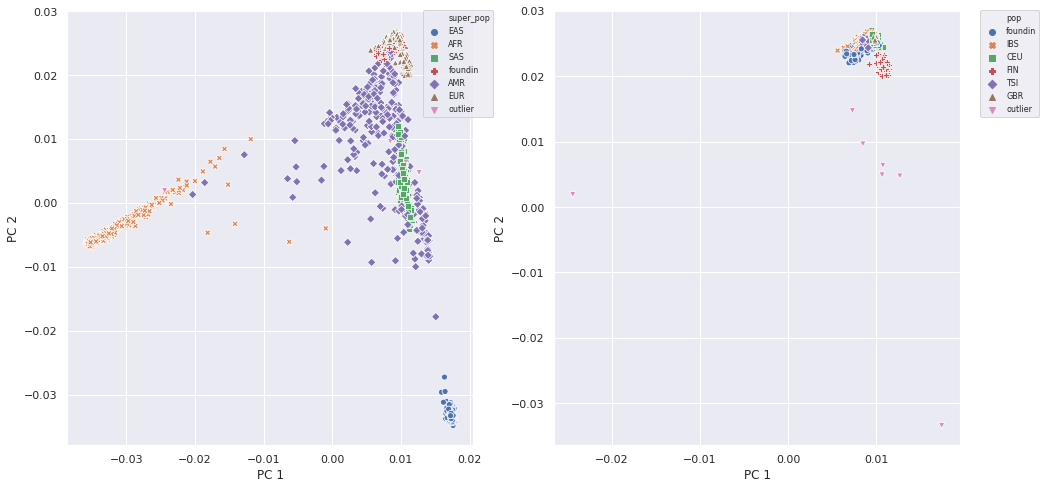

In [21]:
# mdsfile = f'{qc_dir}/{cohort_build}.onekg.ibs_ibd.mds.mds'
mdsfile = f'{qc_dir}/{cohort_build}.onekg.pca.eigenvec'
popinfofile = f'{qc_dir}/onekg.panel'
output_pca_plot = f'{qc_dir}/{cohort_build}.pop_structure.pca.png'
outfile = f'{qc_dir}/{cohort_build}.pop.outliers.txt'

cohort_label = cohort

expected_ancestry = 'EUR'

mdsdf = pd.read_csv(mdsfile,sep='\s+')
infodf = pd.read_csv(popinfofile,sep="\t")

df = mdsdf.merge(infodf,how='left',left_on='IID',right_on='sample')

df[['super_pop']] = df[['super_pop']].fillna(cohort_label)
df[['pop']] = df[['pop']].fillna(cohort_label)

ancestry_cohort = df.loc[df['super_pop'] == expected_ancestry]
coi = df.loc[df['super_pop'] == cohort_label]

mds1_mean = np.mean(ancestry_cohort['PC1'])
mds1_std = np.std(ancestry_cohort['PC1'])
mds2_mean = np.mean(ancestry_cohort['PC2'])
mds2_std = np.std(ancestry_cohort['PC2'])

maxSD = 6
plusMax_1 = mds1_mean + maxSD * mds1_std
negMax_1 = mds1_mean - maxSD * mds1_std
plusMax_2 = mds2_mean + maxSD * mds2_std
negMax_2 = mds2_mean - maxSD * mds2_std

df['outlier'] = ((df['super_pop'] == cohort_label) & \
    ((df['PC1'] > plusMax_1) | (df['PC1'] < negMax_1) | \
     (df['PC2'] > plusMax_2) | (df['PC2'] < negMax_2)))

outliers = df.loc[df['outlier'] == True] 
outliers.to_csv(outfile,sep="\t",index=False,header=False)

df.loc[df['IID'].isin(outliers['IID']),['super_pop','pop']] = 'outlier'

# df = df.sort_values('super_pop',ascending=False)
df = df.sample(frac=1)

cohort_euro_df = df[df['super_pop'].isin([expected_ancestry,cohort_label,'outlier'])]
# cohort_euro_df = cohort_euro_df.sort_values('pop',ascending=False)
# cohort_euro_df = cohort_euro_df.sample(frac=1)

sns.set()
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(x='PC1',y='PC2',hue='super_pop',style='super_pop',data=df)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0,prop={'size': 8})
plt.subplot(1,2,2)
sns.scatterplot(x='PC1',y='PC2',hue='pop',style='pop',data=cohort_euro_df)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0,prop={'size': 8})
#plt.legend(loc='upper right', prop={'size': 6})
plt.savefig(output_pca_plot,format='png',dpi=600,bbox_inches='tight')
plt.show()

In [22]:
cohort_euro_df['pop'].value_counts()

foundin    126
IBS        107
TSI        104
CEU         99
FIN         98
GBR         91
outlier      7
Name: pop, dtype: int64

In [23]:
mdsdf.set_index(mdsdf['IID'], inplace=True)
mdsdf.drop(columns=['#FID','IID'], inplace=True)
mdsdf.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
IID,,,,,,,,,,,,,,,,,,,,
HG00096,0.009828,0.025640,-0.013990,-0.013046,-0.018309,0.003886,0.002421,-0.012768,0.023020,-0.000511,-0.038592,-0.005605,0.006378,0.015131,0.019191,-0.019617,0.009475,0.000383,-0.002568,0.016102
HG00097,0.009775,0.025722,-0.013265,-0.012197,-0.017963,0.001140,0.000535,-0.007785,0.018590,0.001197,-0.038530,-0.009098,0.003690,0.003132,0.006056,-0.014211,0.002362,-0.032590,-0.003648,0.011780
HG00099,0.009749,0.025358,-0.013136,-0.010781,-0.023855,0.005529,-0.001645,-0.014932,0.022006,-0.010957,-0.049408,0.000113,0.009596,0.009993,0.020312,-0.022298,0.005359,0.002686,0.007064,0.007769
HG00100,0.009158,0.025754,-0.013267,-0.012810,-0.015548,0.004975,-0.001190,-0.010990,0.029868,-0.011199,-0.049062,0.002765,0.001763,-0.000739,0.025629,-0.018942,0.007580,-0.016998,-0.012873,0.011012
HG00101,0.009639,0.025338,-0.014290,-0.012088,-0.018808,0.003583,-0.000368,-0.009167,0.021922,-0.007501,-0.049451,0.002324,0.020138,0.009996,0.029893,-0.011501,0.012447,-0.013496,-0.009882,0.003692


In [24]:
'''
small function to generate umap from pandas dataframe, for all features (columns) \
and return back as dataframe with source index intact
'''
def generate_umapdf_from_df(this_df, rnd_digits=3):
    # run UMAP on the data frame features
    umap_results = UMAP(random_state=42).fit_transform(this_df)
    umap_df = pd.DataFrame(umap_results, columns=['x_umap', 'y_umap'],
                           index=this_df.index).round(rnd_digits)

    umap_df = umap_df.merge(this_df,left_index=True, right_index=True)
    print(f'The dimensions of the umap df and the traits are {umap_df.shape}')
    return umap_df

In [25]:
%%time
#run UMAP on the genetic PCs
umap_df = generate_umapdf_from_df(mdsdf)

The dimensions of the umap df and the traits are (2580, 22)
CPU times: user 23.2 s, sys: 407 ms, total: 23.6 s
Wall time: 19.2 s


In [26]:
umap_df = umap_df.merge(infodf,how='left',left_index=True,right_on='sample')

umap_df[['super_pop']] = umap_df[['super_pop']].fillna(cohort_label)
umap_df[['pop']] = umap_df[['pop']].fillna(cohort_label)

umap_df.loc[umap_df['sample'].isin(outliers['IID']),
            ['super_pop','pop']] = 'outlier'

print(umap_df['super_pop'].value_counts())

cohort_euro_df = umap_df[umap_df['super_pop'].isin([expected_ancestry,
                                                    cohort_label, 'outlier'])]
print(cohort_euro_df['pop'].value_counts())

# cohort_euro_df = cohort_euro_df.sort_values('sample',ascending=False)
cohort_euro_df = cohort_euro_df.sample(frac=1)

AFR        657
EAS        499
EUR        499
SAS        481
AMR        311
foundin    126
outlier      7
Name: super_pop, dtype: int64
foundin    126
IBS        107
TSI        104
CEU         99
FIN         98
GBR         91
outlier      7
Name: pop, dtype: int64


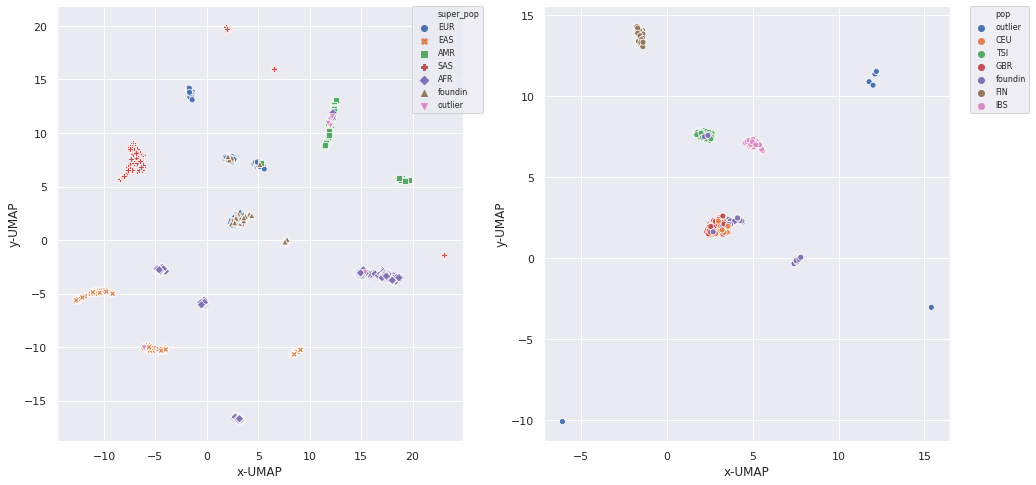

In [27]:
output_plot = f'{qc_dir}/{cohort_build}.ancestry_structure.umap.png'

sns.set()
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.scatterplot(x='x_umap',y='y_umap',hue='super_pop',style='super_pop',data=umap_df)
plt.xlabel('x-UMAP')
plt.ylabel('y-UMAP')
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0,prop={'size': 8})
plt.subplot(1,2,2)
sns.scatterplot(x='x_umap',y='y_umap',hue='pop',data=cohort_euro_df)
plt.xlabel('x-UMAP')
plt.ylabel('y-UMAP')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0,prop={'size': 8})
plt.savefig(output_plot,format='png',dpi=600,bbox_inches='tight')
plt.show()

#### scan qc files for sample QC problems

In [28]:
#sex check mismatches
def check_sexcheck(path_prefix, verbose=False):
    sexcheck_file = f'{path_prefix}.sex.sexcheck'
    sexcheck_df = pd.read_csv(sexcheck_file, sep='\s+')
    #here failed sexcheck does not include unreported sex
    sexcheck_problems_df = sexcheck_df.loc[(sexcheck_df['STATUS'] == 'PROBLEM') & \
                                           (sexcheck_df['PEDSEX'] != 0)]
    print(f'sex mismatches {sexcheck_problems_df.shape}')
    if(verbose):
        print(sexcheck_problems_df)
    return sexcheck_problems_df

#check sample missingness 
def check_missingness(path_prefix, max_miss=0.05, verbose=False):
    smiss_file = f'{path_prefix}.missing.smiss'
    #might be plink1 file extenstion
    if not os.path.exists(smiss_file):
        smiss_file = f'{path_prefix}.missing.imiss'
    smiss_df = pd.read_csv(smiss_file, sep='\s+')
    smiss_problems_df = smiss_df.loc[smiss_df['F_MISS'] > max_miss]
    print(f'sample missingness problems {smiss_problems_df.shape}')
    if(verbose):
        print(smiss_problems_df)
    return smiss_problems_df

#het rate problems
def check_hetrate(path_prefix, abs_max_rate=0.15, verbose=False):
    hetcheck_file = f'{path_prefix}.het.het'
    hetcheck_df = pd.read_csv(hetcheck_file, sep='\s+')
    hetcheck_problems_df = hetcheck_df.loc[(hetcheck_df['F'] > abs_max_rate) | \
                                           (hetcheck_df['F'] < -abs_max_rate)]
    print(f'sample het rate problems {hetcheck_problems_df.shape}')
    if(verbose):
        print(hetcheck_problems_df)    
    return hetcheck_problems_df

#sample contamination problems
def check_contamination(path_prefix, verbose=False):
    contam_file = f'{path_prefix}.contaminated.samples.txt'
    #might not exist if didn't process raw data
    if os.path.exists(contam_file):
        contam_df = pd.read_csv(contam_file, sep='\s+')
        print(f'sample contamination problems {contam_df.shape}')
        if(verbose):
            print(contam_df)         
    else:
        print('no comtamination file present')
        contam_df = pd.DataFrame(data=None, columns=['id'])
    return contam_df        

#check ancestry outliers
def check_ancestry(path_prefix):
    pop_outliers_file = f'{path_prefix}.pop.outliers.txt'
    pop_outliers = pd.read_csv(pop_outliers_file, sep='\s+', header=None)
    print(f'sample ancestry outliers {pop_outliers.shape}')
    return pop_outliers

#check sample duplicates (assume no twins)
def check_duplicates(path_prefix, verbose=False):
    relateds_file = f'{path_prefix}.king.related.kin0'
    duplicates_df = None
    if os.path.isfile(relateds_file):
        relateds_df = pd.read_csv(relateds_file, sep='\s+')
        duplicates_df = relateds_df.loc[relateds_df['InfType'] == 'Dup/MZ']
        print(f'sample duplicate pairs {duplicates_df.shape}')
        if(verbose):
            print(duplicates_df)
    return duplicates_df


def find_sample_excludes(path_prefix, exclude_pops=False):
    sexcheck_problems_df = check_sexcheck(path_prefix)
    smiss_problems_df = check_missingness(path_prefix)
    hetcheck_problems_df = check_hetrate(path_prefix)
#     contam_df = check_contamination(path_prefix)
    pop_outliers = check_ancestry(path_prefix)
    duplicates_df = check_duplicates(path_prefix)
    
#     if exclude_pops:
#         ref_exclude_set = set(sexcheck_problems_df['IID']) | set(smiss_problems_df['IID']) \
# | set(hetcheck_problems_df['IID']) | set(contam_df['id']) | set(pop_outliers[0])
#     else:
#         ref_exclude_set = set(sexcheck_problems_df['IID']) | set(smiss_problems_df['IID']) \
# | set(hetcheck_problems_df['IID']) | set(contam_df['id'])

    if exclude_pops:
        ref_exclude_set = set(sexcheck_problems_df['IID']) | set(smiss_problems_df['IID']) \
| set(hetcheck_problems_df['IID']) | set(pop_outliers[0])
    else:
        ref_exclude_set = set(sexcheck_problems_df['IID']) | set(smiss_problems_df['IID']) \
| set(hetcheck_problems_df['IID'])

    #note to split duplicate pairs, first break any that currently have QC problems
    #then just grab first column
    if not duplicates_df is None:
        duplicates_df = duplicates_df.loc[~duplicates_df['ID1'].isin(list(ref_exclude_set)) & \
                                         ~duplicates_df['ID2'].isin(list(ref_exclude_set))]
        print(f'refreshed duplicate pairs {duplicates_df.shape}')

        #just grab the ID in 1st column to split the pair
        ref_exclude_set = ref_exclude_set | set(duplicates_df['ID1'])

    print(f'number of samples to exclude from panel {len(ref_exclude_set)}')
    return ref_exclude_set

In [29]:
#this of course assumes the files being check in the exclude function exist at \
#this QC path
qc_prefix = f'{qc_dir}/{cohort_build}'
cohort_excludes = find_sample_excludes(qc_prefix, True)

pd.DataFrame(data=cohort_excludes).to_csv(f'{qc_prefix}.excludes.txt', \
                                          header=False, index=False)

sex mismatches (0, 6)
sample missingness problems (0, 5)
sample het rate problems (0, 6)
sample ancestry outliers (7, 25)
sample duplicate pairs (0, 14)
refreshed duplicate pairs (0, 14)
number of samples to exclude from panel 7


#### since there are smallish number of sample QC problems, splill to screen here

In [30]:
sexcheck_problems_df = check_sexcheck(qc_prefix, verbose=True)
smiss_problems_df = check_missingness(qc_prefix, verbose=True)
hetcheck_problems_df = check_hetrate(qc_prefix, verbose=True)
duplicates_df = check_duplicates(qc_prefix, verbose=True)

sex mismatches (0, 6)
Empty DataFrame
Columns: [FID, IID, PEDSEX, SNPSEX, STATUS, F]
Index: []
sample missingness problems (0, 5)
Empty DataFrame
Columns: [#FID, IID, MISSING_CT, OBS_CT, F_MISS]
Index: []
sample het rate problems (0, 6)
Empty DataFrame
Columns: [FID, IID, O(HOM), E(HOM), N(NM), F]
Index: []
sample duplicate pairs (0, 14)
Empty DataFrame
Columns: [FID1, ID1, FID2, ID2, N_SNP, HetHet, IBS0, HetConc, HomIBS0, Kinship, IBD1Seg, IBD2Seg, PropIBD, InfType]
Index: []


#### do a little intermediate file cleanup

In [31]:
!rm {qc_dir}/{cohort_build}.chr*.multiallelics.list
!rm {qc_dir}/{cohort_build}.chr*.geno05maf05hwe000001.*

rm: cannot remove ‘/labshare/raph/datasets/foundin/qc/foundin.freeze9.chr*.multiallelics.list’: No such file or directory


#### subset out the analysis ready, Euro centric, pfiles for eQTL analysis

#### combine the sqc samples and also exclude related samples

In [37]:
# load the relateds file
relateds_file = f'{qc_dir}/{cohort_build}.king.related.kin0'
if os.path.isfile(relateds_file):
    relateds_df = pd.read_csv(relateds_file, sep='\s+')
    # exclude non-duplicate relateds by spliting, dups already marked for exclud
    nonduplicates_df = relateds_df.loc[relateds_df['InfType'] != 'Dup/MZ']

# read the sqc samples
excludes_df = pd.read_csv(sqc_excludes_file, header=None)
print(excludes_df.shape)

# get intersect union of sqc and too young
if not nonduplicates_df is None:
    exclude_ids = set(excludes_df[0]) | set(nonduplicates_df['ID2']) | set(known_excludes)
else:
    exclude_ids = set(excludes_df[0]) | set(known_excludes)
    
print(len(exclude_ids))

(7, 1)
14


In [42]:
def frmt_plink2_subset(in_dir, out_dir, chrom, excludes_file, in_name, out_name):
    if in_dir == out_dir:
        print('in dir cannot be same of out dir, here')
        plink_cmd = '#error'
    else:    
        in_pfiles = f'{in_dir}/{in_name}.chr{chrom}'
        out_pfiles = f'{out_dir}/{out_name}.chr{chrom}'
        filter_pass = ' --var-filter'
        plink_cmd = f'plink2 --pfile {in_pfiles} --remove {excludes_file} \
--silent --make-pgen --out {out_pfiles}'
    return plink_cmd

os.makedirs(eqtl_geno_dir, exist_ok=True)

excludes_df = pd.DataFrame(data=exclude_ids, columns=['#FID'])
excludes_df['IID'] = excludes_df['#FID']
excludes_df.to_csv(f'{qc_dir}/{cohort}.{amppd_version}.excludes.plink', 
                   index=False, sep='\t')

cmds = [frmt_plink2_subset(genos_dir, eqtl_geno_dir, chrom, 
                           f'{qc_dir}/{cohort}.{amppd_version}.excludes.plink',
                           cohort_build, f'{cohort}.{amppd_version}') 
        for chrom in chromosomes] 

# print(cmds)
# now run the cmds concurrently    
run_bash_cmds_threaded(cmds)  

#### generate the with cohort genetic PCs covariates

In [43]:
# find pruned variants
!plink2 --bfile {qc_bfile_set} --silent \
--indep-pairwise 50 5 0.3 --out {qc_dir}/{cohort_build}.ldprune 

# subset to pruned variants
!plink2 --bfile {qc_bfile_set} --silent \
--extract {qc_dir}/{cohort_build}.ldprune.prune.in \
--make-bed --out {qc_dir}/{cohort_build}.pruned

# generate pca's (plink approx from fastpca)
!plink2 --bfile {qc_dir}/{cohort_build}.pruned \
--silent --pca 20 \
--out {eqtl_info_dir}/{cohort_build}.pca


In [44]:
!head -n 5 {eqtl_info_dirfo_dir}/{cohort_build}.pca.eigenvec

#FID	IID	PC1	PC2	PC3	PC4	PC5	PC6	PC7	PC8	PC9	PC10	PC11	PC12	PC13	PC14	PC15	PC16	PC17	PC18	PC19	PC20
PP-3220	PP-3220	-0.109722	-0.0396165	0.00559168	0.00253632	-0.00657915	0.0136283	-0.00547677	0.0260311	0.00991557	0.0252357	-0.0375392	0.0212668	-0.0336066	-0.0032621	-0.0591716	-0.13754	-0.0756335	0.0319667	-0.092246	-0.0332376
PP-3234	PP-3234	-0.0881821	-0.0427902	0.0123654	-0.000961613	-0.0048549	0.00699723	-0.000407525	0.00749441	-0.0035021	0.013008	0.0447273	-0.0483439	-0.0946866	-0.0645941	0.0465031	-0.089895	0.0405065	-0.0133588	-0.00664499	-0.106247
PP-3409	PP-3409	-0.0639142	-0.0296093	0.00770528	0.00719947	0.00859008	-0.00864741	-0.00698471	-0.00816544	0.028941	-0.0539813	-0.00270859	-0.0685604	0.106883	-0.0612086	0.0122347	0.142867	0.171667	-0.0381279	0.00775191	0.0604551
PP-3411	PP-3411	-0.104367	-0.0345118	0.0155618	-0.00897898	-0.0214165	-0.00285945	-0.00260856	0.033061	0.015139	-0.000344092	-0.123841	0.0313518	-0.0456873	0.0421371	-0.12513	-0.00683283	0.0430765	0.0752112	-